In [1]:
from tqdm import tqdm
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import cooler
import pandas as pd
import glob
import seaborn as sns

### 1. Get the maps

In [8]:
chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17',
       'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']

In [7]:
#set path to the individual sampled maps
path_to_maps = "../data/"
files = [file for file in os.listdir(path_to_maps) if "mcool" in file]
files.sort()
files

['sampled_HC-2Mminus_drop_diag_1K.mcool',
 'sampled_HC-2Mplus_drop_diag_1K.mcool',
 'sampled_HC-318minus_drop_diag_1K.mcool',
 'sampled_HC-318plus_drop_diag_1K.mcool',
 'sampled_HC-3Mminus_drop_diag_1K.mcool',
 'sampled_HC-3Mplus_drop_diag_1K.mcool',
 'sampled_HC-91minus_drop_diag_1K.mcool',
 'sampled_HC-91plus_drop_diag_1K.mcool']

### 2. Calculate cis-trans contacts ratio

In [41]:
def compute_cis_trans(hiclist, dropdiag=0, resolution=50000, stable=True, normalized=False):
    interchrom = {}
    for path in hiclist:
        clr = cooler.Cooler(path + '::/resolutions/%d' % resolution)
        sizes = np.array(clr.chromsizes.values) / resolution
        norm = np.outer(sizes, sizes)
        pix = clr.pixels()[:]
        pix_no_diag = pix[pix.bin2_id >= pix.bin1_id + dropdiag] #delete m first diagonals
        bins = clr.bins()[:].drop(labels=['start', 'end'], axis=1)

        cis_trans = np.asarray(
                    pix_no_diag.merge(bins, left_on='bin1_id', right_index=True).\
                                merge(bins, left_on='bin2_id', right_index=True).\
                                groupby(['chrom_x', 'chrom_y']).sum().\
                                unstack(fill_value=0)['count']) #convert to square matrix

        cis_trans = cis_trans + cis_trans.T - np.diag(np.diag(cis_trans))
        if normalized:
            fullsum = np.nansum(cis_trans)
            if fullsum == 0.:
                print('Drop %s due to zero contact sum' % path)
                continue
            cis_trans = cis_trans / fullsum * 2 * 1_000_000 #scale by constant
        if stable:
            cis_trans += 1
        result = cis_trans / norm
        interchrom[os.path.splitext(os.path.basename(clr.filename))[0]] = result 
    return interchrom

In [42]:
def calculate_cis_trans_several_files(files, directory, normalized=False):
    types = [i.split('_')[1].split('-')[1].split("minus")[0] for i in files]
    types = [i for i in types if 'plus' not in i] #["2M", "318", "3M", "91"]
    res_cis_to_trans = {}
    for type in types:
        files_pair = [directory+"/"+file for file in files if type in file]
        print(type)
        res_cis_to_trans[type] = {}
        res_cis_to_trans[type] = compute_cis_trans(files_pair, dropdiag=0, resolution=50000, stable=True, normalized=normalized) 
    return res_cis_to_trans, types

In [45]:
res_cis_to_trans, types = calculate_cis_trans_several_files(files, path_to_maps, normalized=False)

### 3. Visualize cis-trans contacts ratio

In [47]:
def plot_cis_to_trans(map1, map2,  type, vmax=1.45, savepath=None):

    m = map1[:-2, :-2] / map2[:-2, :-2]
    df_corr = pd.DataFrame(m)
    df_corr.index = chroms[:23]
    df_corr.columns = chroms[:23]
    df_corr.columns = [i.split("chr")[1] for i in df_corr.columns.tolist()]
    df_corr.index =  df_corr.columns.tolist()    
    # df_corr = df_corr.reindex(sorter, axis='index').reindex(sorter, axis='columns')
    sns.set(font='Helvetica')
    matplotlib.rcParams['font.family'] = 'Helvetica'
    g = sns.clustermap(df_corr,  
                       figsize = (7.5,7.5), 
                       # figsize = (4.5,4.5),
                       cbar_kws={"orientation": "horizontal"},
                       metric="correlation", cmap="RdBu_r",vmax = vmax, vmin = 1-(vmax-1))
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([x0+0.183, 1.11, g.ax_row_dendrogram.get_position().width+0.555, 0.02])    
    g.fig.suptitle(f"{type} NeuN(+) " + '/ ' + f"{type} NeuN(-)" + '; average=%.3f' % np.nanmean(m), fontsize=16,  y=1.02, x =0.58)    
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=1)    
    sns.set_style("ticks")    
    g.ax_row_dendrogram.set_visible(True)
    g.ax_col_dendrogram.set_visible(True)
    g.cax.yaxis.set_ticks_position("default")   
    if savepath:
        plt.savefig(savepath, dpi=400, bbox_inches='tight', format='pdf')
    plt.show()

0it [00:00, ?it/s]

2M 1.8


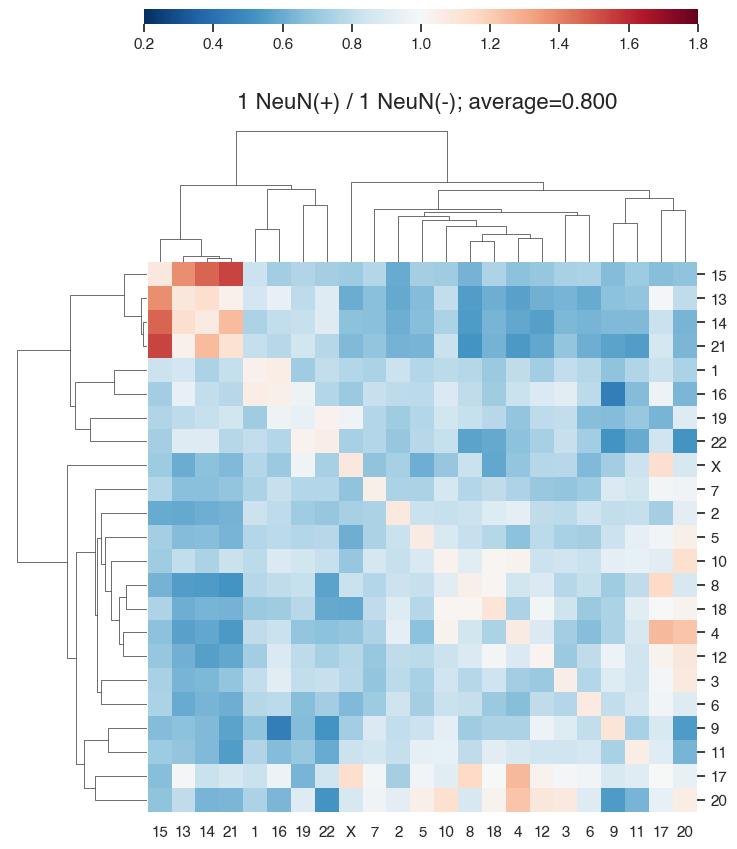

1it [00:00,  1.66it/s]

318 1.9


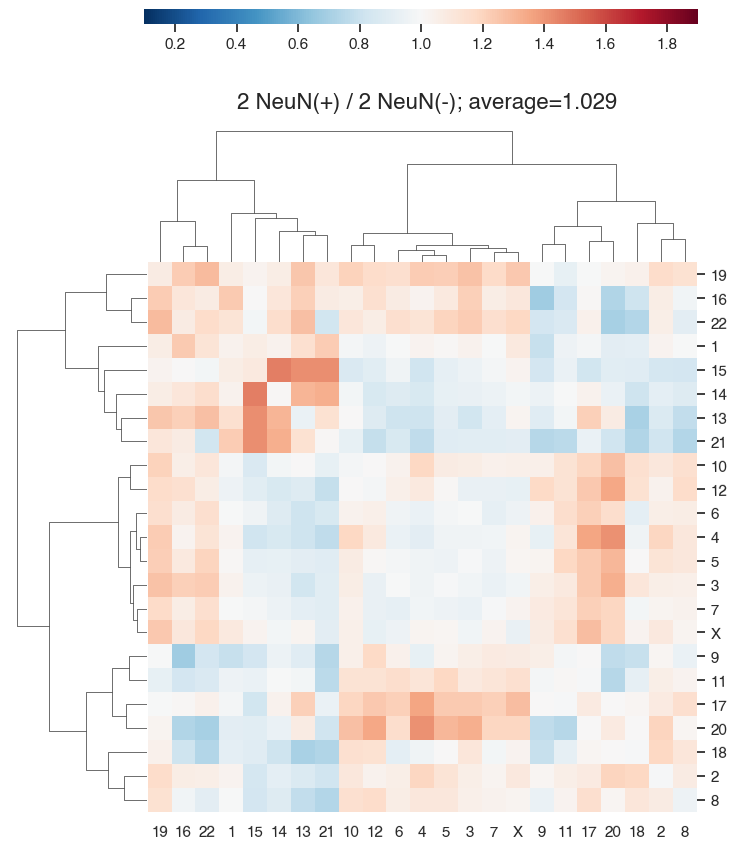

2it [00:01,  1.77it/s]

3M 1.6


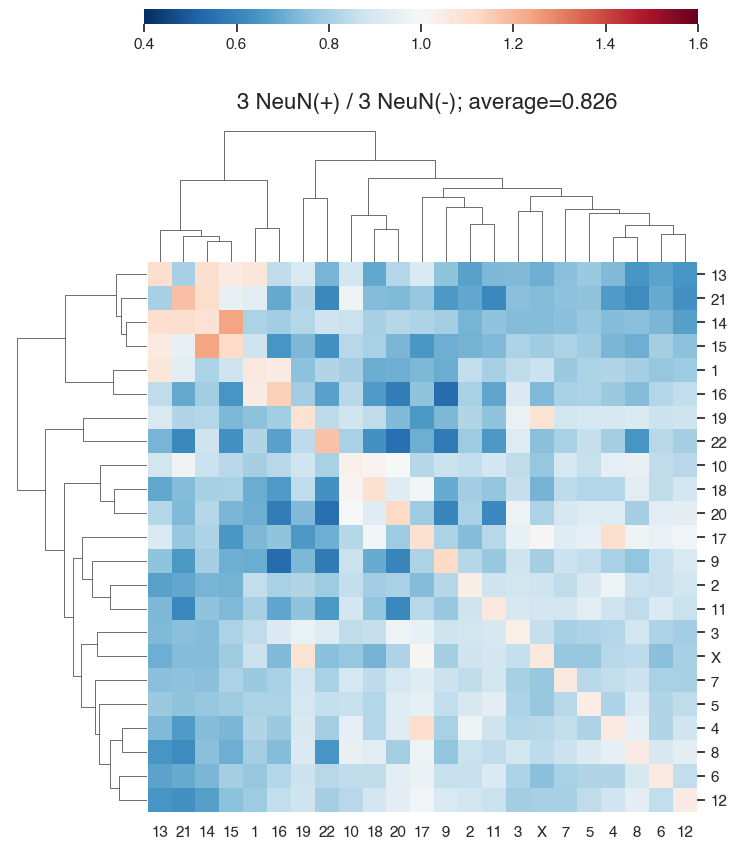

3it [00:01,  1.82it/s]

91 1.7


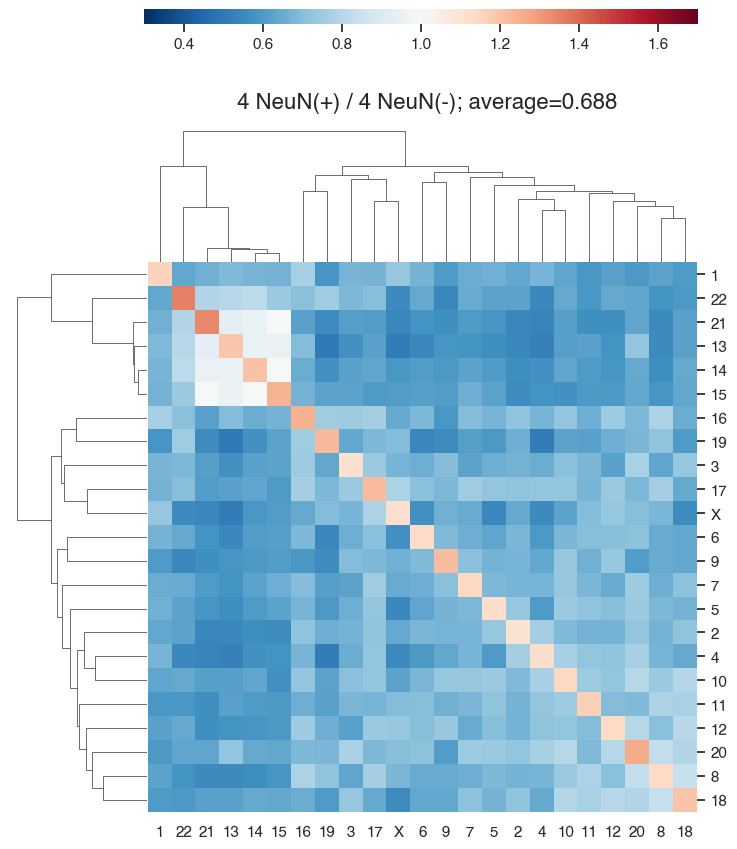

4it [00:02,  1.82it/s]


In [50]:
cnt=0
for type ,vmax in tqdm(zip(types, [1.8 , 1.9, 1.6, 1.7])):
    data = res_cis_to_trans[type]
    print(type ,vmax)
    cnt+=1
    plot_cis_to_trans( res_cis_to_trans[type][f"sampled_HC-{type}plus_drop_diag_1K"], res_cis_to_trans[type][f"sampled_HC-{type}minus_drop_diag_1K"], cnt, vmax=vmax)

### 3. Create box plots

In [61]:
def cis_tran_box_plots_cal(file , type):
    cis_plus = file[type][f"sampled_HC-{type}plus_drop_diag_1K"][:-2, :-2].diagonal()
    cis_minus = file[type][f"sampled_HC-{type}minus_drop_diag_1K"][:-2, :-2].diagonal()
    
    A = file[type][f"sampled_HC-{type}minus_drop_diag_1K"][:-2, :-2]
    trans_minus = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1).flatten()
    
    A = file[type][f"sampled_HC-{type}plus_drop_diag_1K"][:-2, :-2]
    trans_plus = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1).flatten()
    
    new_trans = pd.DataFrame(zip(trans_plus.tolist() + trans_minus.tolist(), ["NeuN+"]*len(trans_plus) + ["NeuN-"]*len(trans_minus)), columns = ["contacts","cell type"])
    new_cis = pd.DataFrame(zip(cis_plus.tolist() + cis_minus.tolist(), ["NeuN+"]*len(cis_plus) + ["NeuN-"]*len(cis_minus)), columns = ["contacts","cell type"])
    new_trans["type_contacts"] = "trans"
    new_cis["type_contacts"] = "cis"
    df = pd.concat([new_trans, new_cis]).reset_index(drop=True)
    df["sample"] = type
    return df

def cis_tran_box_plots_plot(res_box_plot_trans,  add_significance = False, savepath = None):
    plt.figure(figsize=(6.7,4.5))
    my_pal = {"NeuN+": (sns.color_palette()[4]), "NeuN-": (sns.color_palette()[1])}
    sns.set(font_scale=1)
    sns.set_style("whitegrid")
    box_plot= sns.boxplot(data=res_box_plot_trans, x="sample", y="contacts",
                          hue = "cell type",
                          palette=my_pal,   
                           width=0.5
                         )
    box_plot.set_xlabel('')
    box_plot.set_ylabel("Interactions")   
    box_plot.set_ylabel("Interactions")
    if savepath:
        plt.savefig(savepath, dpi=400, bbox_inches='tight', format='pdf')

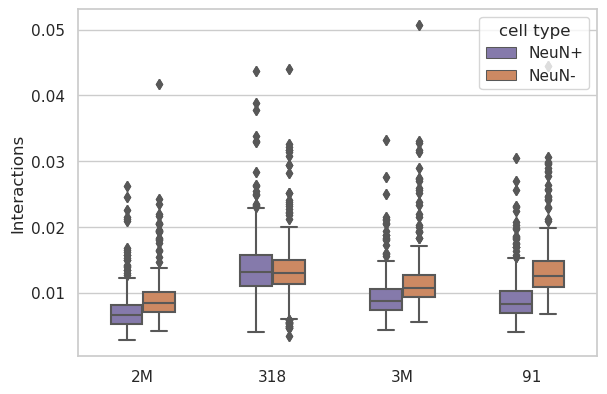

In [63]:
res_box_plot = pd.DataFrame()
for type in types:
    res = cis_tran_box_plots_cal(res_cis_to_trans , type)
    res_box_plot = pd.concat([res_box_plot, res]).reset_index(drop=True)
res_box_plot_trans = res_box_plot[res_box_plot.type_contacts == "trans"].reset_index(drop=True)
res_box_plot_cis = res_box_plot[res_box_plot.type_contacts == "cis"].reset_index(drop=True)

cis_tran_box_plots_plot(res_box_plot_trans,  add_significance = True)